# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';')

# This replicate the dataset to be used in sanity check at the end of section 1
test_azdias = azdias.copy()

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
print("Udacity_AZDIAS_Subset Rows: {} Columns: {}".format(azdias.shape[0], azdias.shape[1]))

Udacity_AZDIAS_Subset Rows: 891221 Columns: 85


In [5]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [6]:
print("AZDIAS_Feature_Summary Rows: {} Columns: {}".format(feat_info.shape[0], feat_info.shape[1]))

AZDIAS_Feature_Summary Rows: 85 Columns: 4


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# Identify missing or unknown data values and convert them to NaNs.
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [8]:
def get_azdias_is_null_column_data(curr_source):
    # Get isnull data from azdias
    azdias_is_null_data = curr_source.isnull().sum()[curr_source.isnull().sum() != 0]

    # Create azdias dict and check the distribution % from each 
    azdias_is_null_data_dict = {'count': azdias_is_null_data.values, 'distribution': (azdias_is_null_data.values / curr_source.shape[0]) * 100 }

    # Create a new data frame for check
    azdias_is_null_data_df = pd.DataFrame(data = azdias_is_null_data_dict, index = azdias_is_null_data.index)
    azdias_is_null_data_df.sort_values(by = 'count', ascending = False, inplace = True)
    azdias_is_null_data_shape = azdias_is_null_data_df.shape
    
    return azdias_is_null_data_df

In [9]:
# Get the current azdias and do the check
azdias_before_cleaning = get_azdias_is_null_column_data(azdias)

print("Total rows {}".format(azdias_before_cleaning.shape[0]))

display(azdias_before_cleaning.head(10))

Total rows 53


,count,distribution
KK_KUNDENTYP,584612,65.596749
KBA05_BAUMAX,133324,14.959701
KBA05_ANTG4,133324,14.959701
KBA05_ANTG1,133324,14.959701
KBA05_ANTG2,133324,14.959701
KBA05_GBZ,133324,14.959701
MOBI_REGIO,133324,14.959701
KBA05_ANTG3,133324,14.959701
KKK,121196,13.598872
REGIOTYP,121196,13.598872


In [10]:
# Help function to check if it a number
def convert_to_int(n):
    try:
        return int(n)
    except ValueError:
        return n

# Reference: https://note.nkmk.me/en/python-check-int-float/

In [11]:
# Get the missing_or_unknown values
missing_or_unknown = feat_info['missing_or_unknown']

# Organize and clean the data from missing_or_unknown
missing_or_unknown_dict = {
    'nan_range': missing_or_unknown.str.strip('[]').str.split(',').values,
    'source': missing_or_unknown.values
}

# Create a new data frame for missing_or_unknown data transformation
missing_or_unknown_df = pd.DataFrame(missing_or_unknown_dict, index = feat_info['attribute'].values)

# Transform 
missing_or_unknown_df['nan_range'] = missing_or_unknown_df.apply(lambda x: [convert_to_int(i) for i in x[0]], axis = 1)

In [12]:
# Check results after transformation
display(missing_or_unknown_df)

,nan_range,source
AGER_TYP,"[-1, 0]","[-1,0]"
ALTERSKATEGORIE_GROB,"[-1, 0, 9]","[-1,0,9]"
ANREDE_KZ,"[-1, 0]","[-1,0]"
CJT_GESAMTTYP,[0],[0]
FINANZ_MINIMALIST,[-1],[-1]
FINANZ_SPARER,[-1],[-1]
FINANZ_VORSORGER,[-1],[-1]
FINANZ_ANLEGER,[-1],[-1]
FINANZ_UNAUFFAELLIGER,[-1],[-1]
FINANZ_HAUSBAUER,[-1],[-1]


In [13]:
# Use the missing_or_unknown_df to replace the values in azdias

def convert_missing_or_unknown_into_nan(df):
    print("Starting convert_missing_or_unknown_into_nan...")
    
    for column in df.columns:
        # Get the missing_or_unknown value from the current column
        nan_value_cell = missing_or_unknown_df.loc[column][0]
        # Replace the missing_or_unknown vaklue to nan
        df[column] = df[column].replace(nan_value_cell, np.nan)
        
    print("Finished convert_missing_or_unknown_into_nan...")
    
    
convert_missing_or_unknown_into_nan(azdias)

Starting convert_missing_or_unknown_into_nan...
Finished convert_missing_or_unknown_into_nan...


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [14]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
azdias_after_cleaning = get_azdias_is_null_column_data(azdias)

print("Total rows {}".format(azdias_after_cleaning.shape[0]))

display(azdias_after_cleaning.head(10))

Total rows 61


,count,distribution
TITEL_KZ,889061,99.757636
AGER_TYP,685843,76.955435
KK_KUNDENTYP,584612,65.596749
KBA05_BAUMAX,476524,53.468668
GEBURTSJAHR,392318,44.020282
ALTER_HH,310267,34.813699
KKK,158064,17.735668
REGIOTYP,158064,17.735668
W_KEIT_KIND_HH,147988,16.605084
KBA05_ANTG3,133324,14.959701


In [15]:
# Investigate patterns in the amount of missing data in each column.
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,205378.000000,888340.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,793846.000000,793947.000000,793846.000000
mean,1.743410,2.757217,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.166686,5.293389,3.071033
std,0.674312,1.009951,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,0.999072,2.303379,1.360532
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.000000
50%,2.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.000000
75%,2.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,3.000000,4.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,9.000000,5.000000


In [16]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Select the first 6 rows
drop_columns = list(azdias_after_cleaning[:6].index.values)
display(drop_columns)

# Drop the selected columns from the dataset
def drop_columns_function(df):
    print("Starting drop_columns_function for the first 6 outliers")
    return df.drop(drop_columns, axis = 1)
   
azdias = drop_columns_function(azdias)

# Check final shape
print("After cleaning Udacity_AZDIAS_Subset Rows: {} Columns: {}".format(azdias.shape[0], azdias.shape[1]))

['TITEL_KZ',
 'AGER_TYP',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'GEBURTSJAHR',
 'ALTER_HH']

Starting drop_columns_function for the first 6 outliers
After cleaning Udacity_AZDIAS_Subset Rows: 891221 Columns: 79


#### Discussion 1.1.2: Assess Missing Data in Each Column

The starting point from Udacity_AZDIAS_Subset.csv give us 53 columns with NaN values, but after making the check with AZDIAS_Feature_Summary.csv, new 5 columns were add with NaN values.

In [17]:
azdias_before_cleaning.head(10)

,count,distribution
KK_KUNDENTYP,584612,65.596749
KBA05_BAUMAX,133324,14.959701
KBA05_ANTG4,133324,14.959701
KBA05_ANTG1,133324,14.959701
KBA05_ANTG2,133324,14.959701
KBA05_GBZ,133324,14.959701
MOBI_REGIO,133324,14.959701
KBA05_ANTG3,133324,14.959701
KKK,121196,13.598872
REGIOTYP,121196,13.598872


In [18]:
azdias_after_cleaning.head(10)

,count,distribution
TITEL_KZ,889061,99.757636
AGER_TYP,685843,76.955435
KK_KUNDENTYP,584612,65.596749
KBA05_BAUMAX,476524,53.468668
GEBURTSJAHR,392318,44.020282
ALTER_HH,310267,34.813699
KKK,158064,17.735668
REGIOTYP,158064,17.735668
W_KEIT_KIND_HH,147988,16.605084
KBA05_ANTG3,133324,14.959701


Considering that after the cleaning and transformation, 6 columns have more than 20% of their values with missing data, I can consider safe removing from the dataset.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [19]:
# How much data is missing in each row of the dataset?
azdias_nan_row_count = azdias.isnull().sum(axis=1)

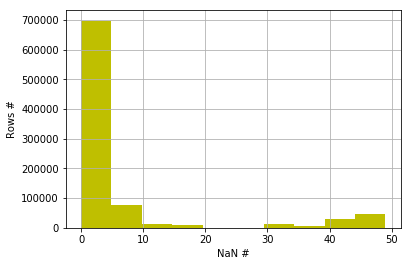

In [20]:
# Plot the general histogram
plt.hist(azdias_nan_row_count, facecolor='y')
plt.xlabel('NaN #')
plt.ylabel('Rows #')
plt.grid(True)

In [21]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_low_25_nan = azdias[azdias_nan_row_count < 25]
azdias_high_25_nan = azdias[azdias_nan_row_count >= 25]

In [22]:
def plot_comparison(column):
    fig = plt.figure(figsize=(7.5,2.5))
    
    fig1 = fig.add_subplot(121)
    fig1.title.set_text('Low < 25')
    sns.countplot(azdias_low_25_nan.loc[:, column])

    fig2 = fig.add_subplot(122)
    fig2.title.set_text('High >= 25')
    sns.countplot(azdias_high_25_nan.loc[:, column]);

    fig.suptitle(column)
    plt.show()

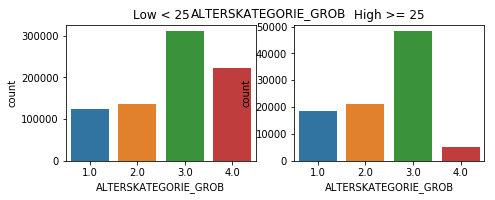

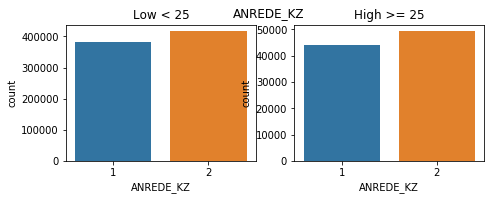

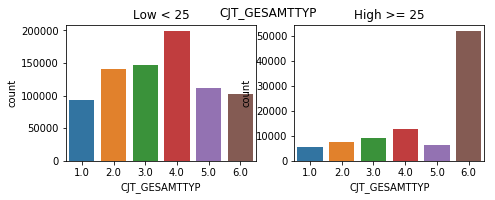

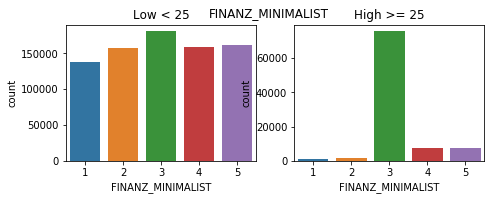

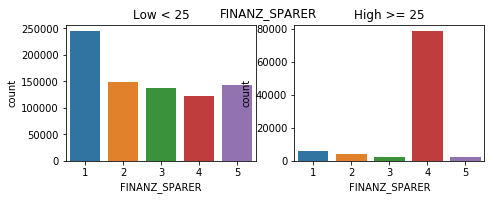

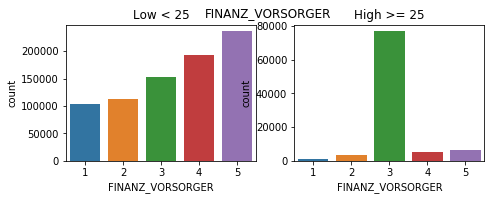

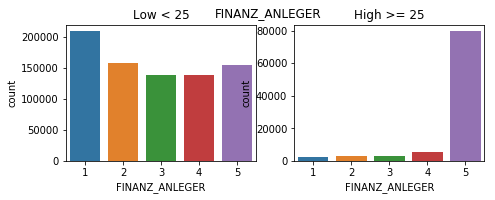

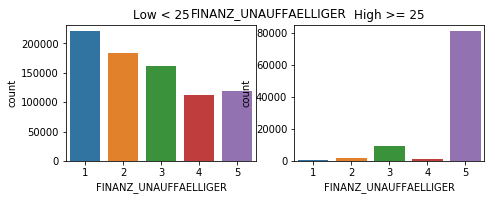

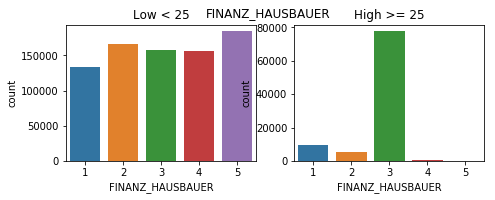

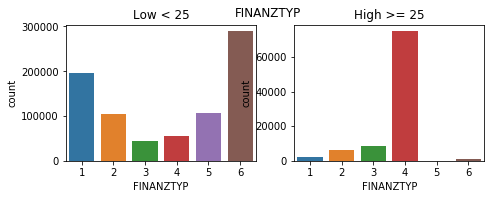

In [23]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

for column in azdias.columns[0:10]:
    plot_comparison(column)

#### Discussion 1.1.3: Assess Missing Data in Each Row


Considering the subsets created from the original dataset and analyzing the graphs, it is possible to conclude that there is a qualitative difference in some of the columns of the original dataset.

In general, 30% of the total lines have some null value (at least 1 NaN value). If we look at the number of lines with more than 25 null values, this percentage is 10,47%.

It is safe to say that the model can be worked lines that have less than 25 null values.

In [24]:
azdias_total_length = len(azdias)
azdias_with_0_nan_length = len(azdias[azdias_nan_row_count == 0])
azdias_low_25_nan_length = len(azdias_low_25_nan)
azdias_high_25_nan_length = len(azdias_high_25_nan)

print("Rows with 0 NaN {}".format(azdias_with_0_nan_length))
print("Rows with < 25 NaN {} - with at least 1 NaN {}".format(azdias_low_25_nan_length, azdias_low_25_nan_length - azdias_with_0_nan_length))
print("Rows with >= 25 NaN {}".format(azdias_high_25_nan_length))

print("{:2f}% rows have some NaN value".format(((azdias_total_length - azdias_with_0_nan_length) / azdias_total_length) * 100))
print("{:2f}% rows with more than 25 NaN values".format((azdias_high_25_nan_length / azdias_total_length) * 100))

Rows with 0 NaN 623209
Rows with < 25 NaN 797906 - with at least 1 NaN 174697
Rows with >= 25 NaN 93315
30.072451% rows have some NaN value
10.470467% rows with more than 25 NaN values


In [25]:
# A helper function to be used in the future
def drop_rows_function(df):
    df_nan_row_count = df.isnull().sum(axis=1)
    df_low_25_nan = df[df_nan_row_count < 25]
    df_high_25_nan = df[df_nan_row_count >= 25]
    print("Executed drop_rows_function with < 25 and >= 25 sub-datasets")
    
    return df_low_25_nan, df_high_25_nan

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [26]:
# How many features are there of each data type?

feat_info.groupby(['type'])['attribute'].count()

type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
Name: attribute, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [27]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Get all categorical_variables
categorical_variables = feat_info[feat_info['type'] == 'categorical']['attribute'].values

# The azdias have some columns dropped before, have to check and use only columns that still exist
categorical_variables = [x for x in categorical_variables if x in azdias_low_25_nan.columns]

binary_subset = [x for x in categorical_variables if azdias_low_25_nan[x].nunique() == 2]
multilevel_subset = [x for x in categorical_variables if azdias_low_25_nan[x].nunique() > 2]

### Binary

In [28]:
for column in binary_subset:
    display(azdias_low_25_nan[column].value_counts())
     
print("Total {} binary".format(len(binary_subset)))

2    416089
1    381817
Name: ANREDE_KZ, dtype: int64

0    622698
1    175208
Name: GREEN_AVANTGARDE, dtype: int64

0.0    791190
1.0      6716
Name: SOHO_KZ, dtype: int64

2.0    394223
1.0    367012
Name: VERS_TYP, dtype: int64

W    629388
O    168518
Name: OST_WEST_KZ, dtype: int64

Total 5 binary


### Multi-level

In [29]:
for column in multilevel_subset:
    display(azdias_low_25_nan[column].value_counts())
    
print("Total {} multi-level".format(len(multilevel_subset)))

4.0    198280
3.0    147203
2.0    141260
5.0    111104
6.0    102075
1.0     93306
Name: CJT_GESAMTTYP, dtype: int64

6    289047
1    197117
5    106321
2    104748
4     55916
3     44757
Name: FINANZTYP, dtype: int64

12.0    130235
10.0    102823
8.0      83028
11.0     75099
5.0      70498
4.0      60422
9.0      57124
3.0      53101
1.0      50656
2.0      43826
7.0      40678
6.0      25738
Name: GFK_URLAUBERTYP, dtype: int64

1.0     402538
10.0    128966
2.0      98548
11.0     48744
8.0      21780
7.0      19575
4.0      11574
5.0      11167
9.0      10452
6.0       8526
3.0       4688
Name: LP_FAMILIE_FEIN, dtype: int64

1.0    402538
5.0    188162
2.0     98548
4.0     49881
3.0     27429
Name: LP_FAMILIE_GROB, dtype: int64

1.0     206852
9.0     136344
10.0    111573
2.0     111100
4.0      73969
3.0      68917
6.0      28894
5.0      27582
8.0      18794
7.0       9203
Name: LP_STATUS_FEIN, dtype: int64

1.0    317952
2.0    170468
4.0    155138
5.0    111573
3.0     38097
Name: LP_STATUS_GROB, dtype: int64

1.0    667832
2.0     63643
3.0     32560
Name: NATIONALITAET_KZ, dtype: int64

1.0    247373
2.0    205926
3.0    180813
0.0    127123
Name: SHOPPER_TYP, dtype: int64

3    282178
4    207510
1    123414
5     80956
6     70860
2     32988
Name: ZABEOTYP, dtype: int64

1.0    460370
3.0    178646
8.0    152469
2.0      4899
4.0       897
6.0       624
5.0         1
Name: GEBAEUDETYP, dtype: int64

8    134437
9    108176
6    105872
4    103898
3     86754
2     83220
7     77933
5     55299
1     36211
Name: CAMEO_DEUG_2015, dtype: int64

6B    56671
8A    52435
4C    47814
2D    35073
3C    34763
7A    34399
3D    34304
8B    33434
4A    33149
8C    30992
9D    28593
9B    27676
9C    24987
7B    24503
9A    20542
2C    19420
8D    17576
6E    16107
2B    15482
5D    14943
6C    14820
2A    13245
5A    12203
1D    11909
1A    10850
3A    10532
5B    10354
5C     9935
7C     9065
4B     9045
4D     8570
3B     7155
6A     6809
9E     6378
6D     6073
6F     5392
7D     5333
4E     5320
1E     5065
7E     4633
1C     4316
5F     4283
1B     4071
5E     3581
Name: CAMEO_DEU_2015, dtype: int64

Total 13 multi-level


In [30]:
# Re-encode categorical variable(s) to be kept in the analysis.
def clean_OST_WEST_KZ(df):
    df['OST_WEST_KZ'].replace(['W','O'], [1,0], inplace = True)
    print("Executed clean_OST_WEST_KZ")

clean_OST_WEST_KZ(azdias_low_25_nan)

Executed clean_OST_WEST_KZ


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [31]:
# Check the results after enconding
for column in binary_subset:
    display(azdias_low_25_nan[column].value_counts())

2    416089
1    381817
Name: ANREDE_KZ, dtype: int64

0    622698
1    175208
Name: GREEN_AVANTGARDE, dtype: int64

0.0    791190
1.0      6716
Name: SOHO_KZ, dtype: int64

2.0    394223
1.0    367012
Name: VERS_TYP, dtype: int64

1    629388
0    168518
Name: OST_WEST_KZ, dtype: int64

In [32]:
# Set dummies for multilevel columns
def df_get_dummies_multilevel_subset(df):
    print("Executed df_get_dummies_multilevel_subset")
    return pd.get_dummies(df, columns = multilevel_subset)

azdias_low_25_nan = df_get_dummies_multilevel_subset(azdias_low_25_nan)

Executed df_get_dummies_multilevel_subset


#### Discussion 1.2.1: Re-Encode Categorical Features

It was possible to find 4 binary variables, 1 of which needed to be corrected. I found 13 variables with multiple levels, 1 of which had more than 44 different values.

I also used the pd.get_dummies method to encode all multi-level variables.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [33]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_low_25_nan[['PRAEGENDE_JUGENDJAHRE']].head()

,PRAEGENDE_JUGENDJAHRE
1,14.0
2,15.0
3,8.0
4,8.0
5,3.0


In [34]:
# Generation fill function
generation_dict = {0: [1, 2], 1: [3, 4], 2: [5, 6, 7], 3: [8, 9], 4: [10, 11, 12, 13], 5:[14, 15]}

def fill_generation(value):
    try:
        for key, obj in generation_dict.items():
            if value in obj:
                return key
    except ValueError:
        return np.nan
    
# Movement fill function
movement_list = [1, 3, 5, 8, 10, 12, 14]

def fill_movement(value):
    try:
        if value in movement_list:
            return 0
        else:
            return 1
    except ValueError:
        return np.nan

In [35]:
# Populate the 2 new columns
def enhance_PRAEGENDE_JUGENDJAHRE(df):
    df['PRAEGENDE_JUGENDJAHRE_DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(fill_generation)
    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(fill_movement)
    print("Executed enhance_PRAEGENDE_JUGENDJAHRE")

enhance_PRAEGENDE_JUGENDJAHRE(azdias_low_25_nan)

Executed enhance_PRAEGENDE_JUGENDJAHRE


In [36]:
# Check new columns
display(azdias_low_25_nan[['PRAEGENDE_JUGENDJAHRE_DECADE', 'PRAEGENDE_JUGENDJAHRE_MOVEMENT']].head())

,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT
1,5.0,0
2,5.0,1
3,3.0,0
4,3.0,0
5,1.0,0


In [37]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_low_25_nan[['CAMEO_INTL_2015']].head()

,CAMEO_INTL_2015
1,51
2,24
3,12
4,43
5,54


In [38]:
# Life stage fill function
def fill_lifestage(value):
    return np.nan if pd.isnull(value) else int(str(value)[1])

# Wealth fill function
def fill_wealth(value):
    return np.nan if pd.isnull(value) else int(str(value)[0])

In [39]:
# Populate the 2 new columns
def enhance_CAMEO_INTL_2015(df):
    df['CAMEO_INTL_2015_LIFESTAGE'] = df['CAMEO_INTL_2015'].apply(fill_lifestage)
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(fill_wealth)
    print("Executed enhance_CAMEO_INTL_2015")

enhance_CAMEO_INTL_2015(azdias_low_25_nan)

Executed enhance_CAMEO_INTL_2015


In [40]:
# Check new columns
display(azdias_low_25_nan[['CAMEO_INTL_2015_LIFESTAGE', 'CAMEO_INTL_2015_WEALTH']].head())

,CAMEO_INTL_2015_LIFESTAGE,CAMEO_INTL_2015_WEALTH
1,1.0,5.0
2,4.0,2.0
3,2.0,1.0
4,3.0,4.0
5,4.0,5.0


In [41]:
# Drop PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015
def drop_enhanced_fields(df, fields):
    print("Executed drop_enhanced_fields with {} fields".format(len(fields)))
    return df.drop(fields, axis = 1)

azdias_low_25_nan = drop_enhanced_fields(azdias_low_25_nan, ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'])

Executed drop_enhanced_fields with 2 fields


#### Discussion 1.2.2: Engineer Mixed-Type Features

For the PRAEGENDE_JUGENDJAHRE column, the generation and movement values were created based on the initial model values.

In the CAMEO_INTL_2015 column, the values of the lifestage and wealth were created, following the same strategy previously applied.

The new features are integers, so there is no need to be hot enconded. I also take in consideration to do a sanity check before continue.

At the end of the procedure, I decided to eliminate the original columns to avoid duplication of data.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [42]:
# Check data types
np.unique(azdias_low_25_nan.dtypes.values)

array([dtype('uint8'), dtype('int64'), dtype('float64')], dtype=object)

In [43]:
# Get columns name
list(azdias_after_cleaning.index.values)

['TITEL_KZ',
 'AGER_TYP',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'GEBURTSJAHR',
 'ALTER_HH',
 'KKK',
 'REGIOTYP',
 'W_KEIT_KIND_HH',
 'KBA05_ANTG3',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_GBZ',
 'KBA05_ANTG4',
 'MOBI_REGIO',
 'PLZ8_ANTG2',
 'PLZ8_ANTG1',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4',
 'PLZ8_BAUMAX',
 'PLZ8_HHZ',
 'PLZ8_GBZ',
 'VERS_TYP',
 'SHOPPER_TYP',
 'HEALTH_TYP',
 'NATIONALITAET_KZ',
 'PRAEGENDE_JUGENDJAHRE',
 'KBA13_ANZAHL_PKW',
 'ANZ_HAUSHALTE_AKTIV',
 'CAMEO_INTL_2015',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'LP_LEBENSPHASE_FEIN',
 'ARBEIT',
 'RELAT_AB',
 'ORTSGR_KLS9',
 'ANZ_HH_TITEL',
 'LP_LEBENSPHASE_GROB',
 'INNENSTADT',
 'BALLRAUM',
 'EWDICHTE',
 'GEBAEUDETYP_RASTER',
 'WOHNLAGE',
 'OST_WEST_KZ',
 'MIN_GEBAEUDEJAHR',
 'GEBAEUDETYP',
 'LP_FAMILIE_GROB',
 'LP_FAMILIE_FEIN',
 'KONSUMNAEHE',
 'WOHNDAUER_2008',
 'ANZ_TITEL',
 'ANZ_PERSONEN',
 'SOHO_KZ',
 'HH_EINKOMMEN_SCORE',
 'RETOURTYP_BK_S',
 'LP_STATUS_GROB',
 'LP_STATUS_FEIN',
 'GFK_URLAUBERTYP',
 'CJT_GESAMTTYP',
 'ONLINE_A

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [44]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    convert_missing_or_unknown_into_nan(df)
    
    # remove selected columns and rows, ...
    df = drop_columns_function(df)
    df_low_25_nan, df_high_25_nan = drop_rows_function(df)
    
    # select, re-encode, and engineer column values.
    clean_OST_WEST_KZ(df_low_25_nan)
    df_low_25_nan = df_get_dummies_multilevel_subset(df_low_25_nan)
    enhance_PRAEGENDE_JUGENDJAHRE(df_low_25_nan)
    enhance_CAMEO_INTL_2015(df_low_25_nan)
    df_low_25_nan = drop_enhanced_fields(df_low_25_nan, ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'])
    
    # Return the cleaned dataframe.
    return df_low_25_nan, df_high_25_nan

In [45]:
# Sanity check

# Clean the new dataset with the clean_data
test_azdias_low_25_nan, test_azdias_high_25_nan = clean_data(test_azdias)

# Get shapes to compare
test_azdias_low_25_nan_shape = test_azdias_low_25_nan.shape
azdias_low_25_nan_shape = azdias_low_25_nan.shape

print("Study Udacity_AZDIAS_Subset.csv cleaned with {} rows and {} columns".format(azdias_low_25_nan_shape[0], azdias_low_25_nan_shape[1]))
print("Test Udacity_AZDIAS_Subset.csv cleaned with {} rows and {} columns".format(test_azdias_low_25_nan_shape[0], test_azdias_low_25_nan_shape[1]))


Starting convert_missing_or_unknown_into_nan...
Finished convert_missing_or_unknown_into_nan...
Starting drop_columns_function for the first 6 outliers
Executed drop_rows_function with < 25 and >= 25 sub-datasets


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Executed clean_OST_WEST_KZ
Executed df_get_dummies_multilevel_subset
Executed enhance_PRAEGENDE_JUGENDJAHRE
Executed enhance_CAMEO_INTL_2015
Executed drop_enhanced_fields with 2 fields
Study Udacity_AZDIAS_Subset.csv cleaned with 797906 rows and 196 columns
Test Udacity_AZDIAS_Subset.csv cleaned with 797906 rows and 196 columns


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [46]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

azdias_low_25_nan_copy = azdias_low_25_nan.copy()

# Impute nans
imputer = Imputer()
imputed_azdias_low_25_nan = imputer.fit_transform(azdias_low_25_nan_copy)

In [47]:
# Apply feature scaling to the general population demographics data.
standard_scaler = StandardScaler()
standardized_azdias_low_25_nan = standard_scaler.fit_transform(imputed_azdias_low_25_nan)

In [48]:
# Checking the dataset after standardized
standardized_azdias_low_25_nan = pd.DataFrame(standardized_azdias_low_25_nan, columns = azdias_low_25_nan_copy.columns)
standardized_azdias_low_25_nan.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_LIFESTAGE,CAMEO_INTL_2015_WEALTH
0,-1.766002,0.957932,-1.494563,1.537958,-1.040677,1.466028,0.958855,1.339191,-0.530442,1.085862,...,-0.150079,-0.162558,-0.189558,-0.1798,-0.192787,-0.089765,1.165639,-0.585896,-1.266339,1.191195
1,0.201254,0.957932,-1.494563,0.864598,-1.766947,-0.570971,0.244297,1.339191,1.885219,1.085862,...,-0.150079,-0.162558,-0.189558,-0.1798,-0.192787,-0.089765,1.165639,1.706788,0.761924,-0.865173
2,1.184882,0.957932,0.683201,-0.482123,1.138132,-0.570971,-1.184817,-0.791446,-0.530442,-0.269876,...,-0.150079,-0.162558,-0.189558,-0.1798,-0.192787,-0.089765,-0.231990,-0.585896,-0.590251,-1.550630
3,0.201254,-1.043916,0.683201,0.191237,0.411863,-1.249970,0.244297,-0.791446,-0.530442,1.085862,...,-0.150079,-0.162558,-0.189558,-0.1798,-0.192787,-0.089765,-0.231990,-0.585896,0.085836,0.505739
4,-1.766002,0.957932,-0.042721,-1.155483,1.138132,-0.570971,-0.470260,1.339191,-0.530442,1.085862,...,-0.150079,-0.162558,-0.189558,-0.1798,-0.192787,-0.089765,-1.629618,-0.585896,0.761924,1.191195
5,-0.782374,0.957932,-1.494563,1.537958,-1.766947,1.466028,0.958855,-0.081234,-0.530442,-0.269876,...,-0.150079,-0.162558,-0.189558,-0.1798,-0.192787,-0.089765,0.466825,-0.585896,-0.590251,-0.865173
6,-1.766002,-1.043916,-0.042721,0.191237,0.411863,-1.249970,0.244297,-0.791446,-0.530442,-1.625614,...,-0.150079,-0.162558,-0.189558,-0.1798,-0.192787,-0.089765,-0.231990,-0.585896,0.761924,-1.550630
7,0.201254,-1.043916,0.683201,0.864598,-1.040677,0.787029,-0.470260,-0.791446,1.885219,1.085862,...,-0.150079,-0.162558,-0.189558,-0.1798,-0.192787,-0.089765,0.466825,1.706788,0.085836,-1.550630
8,0.201254,0.957932,-0.768642,0.864598,-1.040677,0.108029,1.673412,0.628979,1.885219,-0.269876,...,-0.150079,-0.162558,-0.189558,-0.1798,-0.192787,-0.089765,1.165639,1.706788,1.438011,-1.550630
9,0.201254,0.957932,-0.768642,-0.482123,1.138132,0.108029,-1.184817,1.339191,-0.530442,-0.269876,...,-0.150079,-0.162558,-0.189558,-0.1798,5.187065,-0.089765,-1.629618,-0.585896,-1.266339,1.191195


### Discussion 2.1: Apply Feature Scaling

I cleaned the dataset from missing values with the mean value from each column. The mean strategy was a good option considering the performance. I also standardized using *StandardScaler*, as suggested.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [49]:
# Apply PCA to the data.
pca = PCA(whiten = True)
pca_azdias_low_25_nan = pca.fit_transform(standardized_azdias_low_25_nan)

In [50]:
def scree_plot(pca):
    pca_evr = pca.explained_variance_ratio_
    num_components = len(pca_evr)
    x = np.arange(num_components)
    cumsum_pca_evr = np.cumsum(pca_evr)
    
    plt.figure(figsize = (20, 10))
    ax = plt.subplot(111)
    
    ax.set_xlabel("Component (#)")
    ax.set_ylabel("Variance (%)")
    
    ax.bar(x, pca_evr)
    ax.plot(x, cumsum_pca_evr)
 
    ax.xaxis.set_tick_params(width = 0)
    ax.yaxis.set_tick_params(width = 2, length = 12)

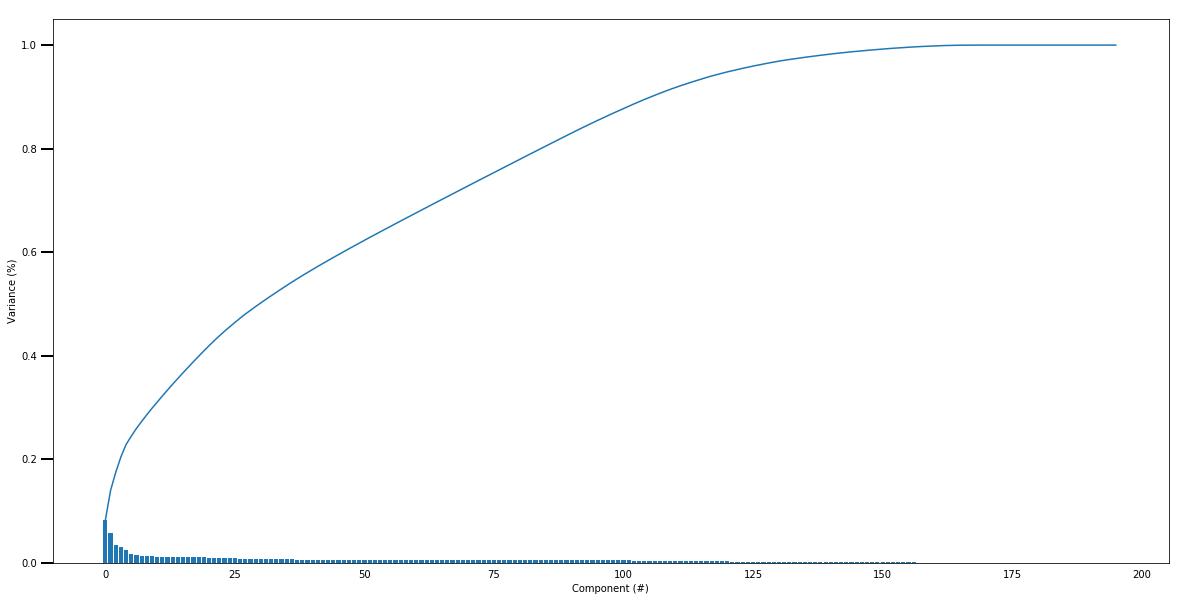

In [51]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca)

In [52]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_100 = PCA(n_components = 100)
pca_100_components = pca_100.fit_transform(standardized_azdias_low_25_nan)

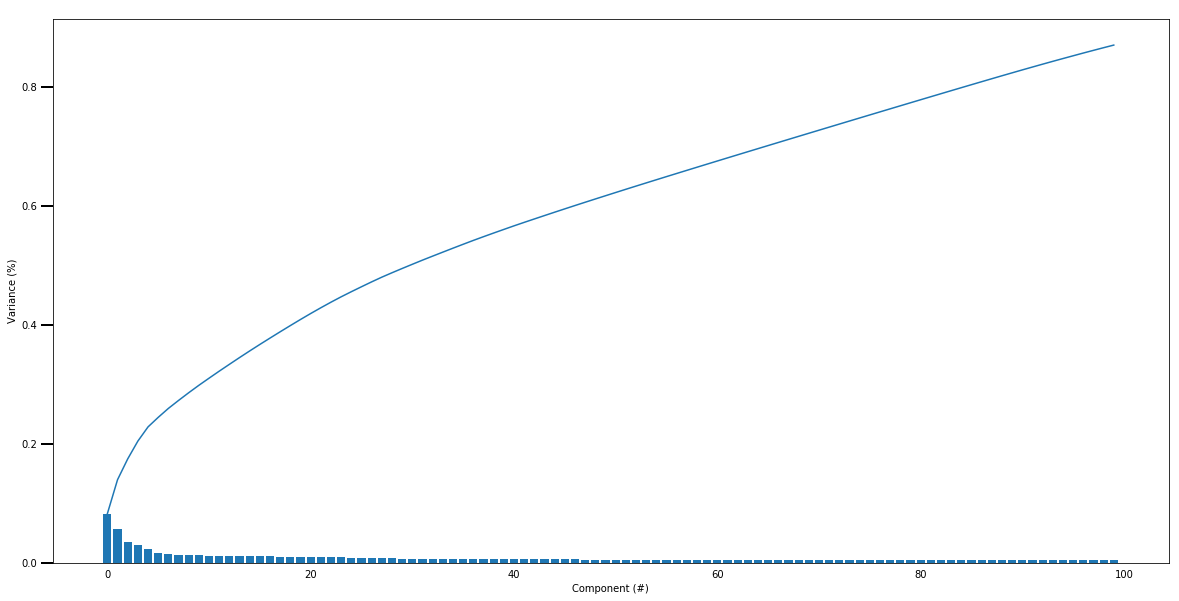

In [53]:
scree_plot(pca_100)

### Discussion 2.2: Perform Dimensionality Reduction


As can be seen in the first analysis with almost 200 components, it is possible to see that half of these components are responsible for 80% of the variation. For that reason, my decision was to take only 100 components to the next stage.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [54]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def get_pca_weight(df, pca, i):
    weights = pd.DataFrame(pca.components_, columns = list(df.columns)).iloc[i]
    weights.sort_values(ascending = False, inplace = True)
    
    return weights

get_pca_weight(standardized_azdias_low_25_nan, pca_100, 0)

LP_STATUS_GROB_1.0                0.188881
CAMEO_INTL_2015_WEALTH            0.180025
HH_EINKOMMEN_SCORE                0.179932
PLZ8_ANTG3                        0.179820
PLZ8_ANTG4                        0.174582
PLZ8_BAUMAX                       0.170426
ORTSGR_KLS9                       0.153814
EWDICHTE                          0.152200
FINANZ_HAUSBAUER                  0.146947
LP_STATUS_FEIN_1.0                0.127164
KBA05_ANTG4                       0.124502
PLZ8_ANTG2                        0.123195
ANZ_HAUSHALTE_AKTIV               0.113175
ARBEIT                            0.111915
KBA05_ANTG3                       0.111263
CAMEO_DEUG_2015_9                 0.110277
LP_STATUS_FEIN_2.0                0.106147
RELAT_AB                          0.105688
FINANZTYP_1                       0.101820
FINANZ_SPARER                     0.099598
LP_FAMILIE_FEIN_1.0               0.098755
LP_FAMILIE_GROB_1.0               0.098755
CAMEO_DEUG_2015_8                 0.090551
ZABEOTYP_5 

In [55]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
get_pca_weight(standardized_azdias_low_25_nan, pca_100, 1)

ALTERSKATEGORIE_GROB            0.237375
FINANZ_VORSORGER                0.223425
ZABEOTYP_3                      0.199161
SEMIO_ERL                       0.180867
SEMIO_LUST                      0.166028
RETOURTYP_BK_S                  0.155379
W_KEIT_KIND_HH                  0.127834
CJT_GESAMTTYP_2.0               0.110953
FINANZ_MINIMALIST               0.101870
FINANZTYP_5                     0.097805
FINANZTYP_2                     0.097149
LP_STATUS_FEIN_1.0              0.086113
SHOPPER_TYP_3.0                 0.075300
FINANZ_HAUSBAUER                0.074916
CJT_GESAMTTYP_1.0               0.071745
NATIONALITAET_KZ_1.0            0.071540
SEMIO_KRIT                      0.070450
FINANZTYP_6                     0.068664
LP_FAMILIE_GROB_1.0             0.059296
LP_FAMILIE_FEIN_1.0             0.059296
GFK_URLAUBERTYP_4.0             0.057959
WOHNDAUER_2008                  0.056935
EWDICHTE                        0.052897
SEMIO_KAEM                      0.052486
ORTSGR_KLS9     

In [56]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
get_pca_weight(standardized_azdias_low_25_nan, pca_100, 2)

SEMIO_VERT                        0.317014
SEMIO_FAM                         0.257926
SEMIO_SOZ                         0.255322
SEMIO_KULT                        0.249314
FINANZTYP_5                       0.135732
FINANZ_MINIMALIST                 0.132086
SHOPPER_TYP_0.0                   0.121941
ZABEOTYP_1                        0.121267
SEMIO_REL                         0.112468
SEMIO_MAT                         0.087903
GREEN_AVANTGARDE                  0.083827
RETOURTYP_BK_S                    0.073630
PRAEGENDE_JUGENDJAHRE_MOVEMENT    0.068965
ORTSGR_KLS9                       0.068562
EWDICHTE                          0.068043
LP_STATUS_FEIN_10.0               0.061089
LP_STATUS_GROB_5.0                0.061089
W_KEIT_KIND_HH                    0.057314
PLZ8_BAUMAX                       0.053166
SHOPPER_TYP_1.0                   0.052689
PLZ8_ANTG4                        0.050958
PLZ8_ANTG3                        0.050256
ZABEOTYP_6                        0.046516
FINANZ_VORS

### Discussion 2.3: Interpret Principal Components

Considering the report generated from the first few principal components generated, the following considerations are important:

### 1st principal component
1st principal component has positive association with the following features:

* LP_STATUS_GROB_1.0                0.188881 - Social status, rough scale
* CAMEO_INTL_2015_WEALTH            0.180025 - Wealth / Life Stage Typology, mapped to international code
* HH_EINKOMMEN_SCORE                0.179932 - Estimated household net income

...while the negative association with following features:

* PLZ8_ANTG1                       -0.180374 - Number of 1-2 family houses in the PLZ8 region
* KBA05_ANTG1                      -0.186416 - Number of 1-2 family houses in the microcell
* MOBI_REGIO                       -0.199553 - Movement patterns

It is possible to assume that this component is linked to financial factors of individuals.


### 2nd principal component
2nd principal component has positive association with the following features:

* ALTERSKATEGORIE_GROB            0.237375 - Estimated age based on given name analysis
* FINANZ_VORSORGER                0.223425 - Financial typology
* ZABEOTYP_3                      0.199161 - Energy consumption typology

...while the negative association with following features:

* SEMIO_REL                      -0.217705 - Personality typology
* FINANZ_SPARER                  -0.234036 - Financial typology
* PRAEGENDE_JUGENDJAHRE_DECADE   -0.241639 - Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)

It is possible to assume that this component of the individual's age and behavior with finances.

### 3rd principal component
3rd principal component has positive association with the following features:

* SEMIO_VERT                        0.317014 - Personality typology
* SEMIO_FAM                         0.257926 - Personality typology
* SEMIO_SOZ                         0.255323 - Personality typology

...while the negative association with following features:

* SEMIO_DOM                        -0.279001 - Personality typology
* SEMIO_KAEM                       -0.311188 - Personality typology
* ANREDE_KZ                        -0.342029 - Gender

It is possible to assume that this component is related to the individual's personality and gender.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [57]:
def apply_clustering(max_clusters, pca_components):
    start_time = time.time()
    
    distances = []
    scores = []
    
    print("Calculating for {} clusters".format(max_clusters))
    
    # Over a number of different cluster counts...
    for n_clusters in range(2, max_clusters + 1, 1):
        sub_start_time = time.time()
            
        # Tun k-means clustering on the data and...
        kmeans = KMeans(n_clusters = n_clusters).fit(pca_100_components)

        # Get score
        score = np.abs(kmeans.score(pca_100_components))
        scores.append(score)

        # Save distance
        distance = score / pca_100_components.shape[0]

        # compute the average within-cluster distances.
        distances.append(distance)

        # Print results
        sub_run_time = np.round(((time.time() - sub_start_time) / 60), 2)
        print("n_clusters = {} ... distances = {} . Run time: {} minutes".format(n_clusters, distance, sub_run_time))
        
    run_time = np.round(((time.time() - start_time) / 60), 2)
    print("Total calculating time: {} minutes ---".format(run_time))
    
    return distances, scores

In [58]:
def plot_cluster_distance(distances, max_clusters):
    plt.plot(range(2, max_clusters + 1, 1), distances, linestyle = '-', marker = 'o');
    
    plt.ylabel('Average within-cluster distances');
    plt.xlabel('K');
    
    plt.title("{} clusters".format(max_clusters));

In [59]:
# Try with 5 clusters
distances_5_clusters, scores_5_clusters = apply_clustering(5, pca_100_components)

Calculating for 5 clusters
n_clusters = 2 ... distances = 158.25613290425483 . Run time: 0.96 minutes
n_clusters = 3 ... distances = 152.69310890154762 . Run time: 1.64 minutes
n_clusters = 4 ... distances = 148.95060977049047 . Run time: 1.96 minutes
n_clusters = 5 ... distances = 145.90809774136233 . Run time: 2.3 minutes
Total calculating time: 6.86 minutes ---


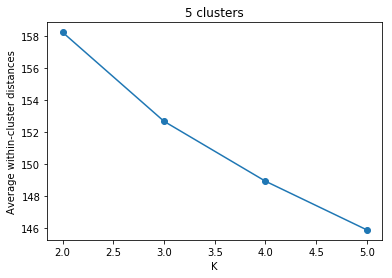

In [60]:
plot_cluster_distance(distances_5_clusters, 5)

In [61]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

# Try with 15 clusters
distances_15_clusters, scores_15_clusters = apply_clustering(15, pca_100_components)

Calculating for 15 clusters
n_clusters = 2 ... distances = 158.25613414303214 . Run time: 0.84 minutes
n_clusters = 3 ... distances = 152.693093260812 . Run time: 1.42 minutes
n_clusters = 4 ... distances = 148.95060681149093 . Run time: 1.75 minutes
n_clusters = 5 ... distances = 145.90809355326093 . Run time: 2.09 minutes
n_clusters = 6 ... distances = 144.01357291257457 . Run time: 3.15 minutes
n_clusters = 7 ... distances = 142.17756340629634 . Run time: 3.59 minutes
n_clusters = 8 ... distances = 140.710283314678 . Run time: 3.85 minutes
n_clusters = 9 ... distances = 139.4107921308025 . Run time: 3.82 minutes
n_clusters = 10 ... distances = 138.38663433049655 . Run time: 5.22 minutes
n_clusters = 11 ... distances = 136.98788726119287 . Run time: 4.56 minutes
n_clusters = 12 ... distances = 136.10496160378906 . Run time: 6.55 minutes
n_clusters = 13 ... distances = 135.03742114588107 . Run time: 6.68 minutes
n_clusters = 14 ... distances = 134.10859526314778 . Run time: 8.59 minut

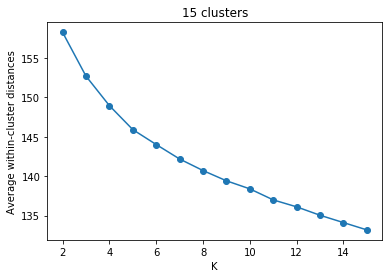

In [62]:
# Plot grpahs
plot_cluster_distance(distances_15_clusters, 15)

In [64]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

def kmeans_cluster(n_clusters, pca_components):
    start_time = time.time()
    
    # Get kmeans
    kmeans = KMeans(n_clusters).fit(pca_components)
    
    # Predict
    kmeans_predict = kmeans.predict(pca_components)
    
    run_time = np.round(((time.time() - start_time) / 60), 2)
    print("Total calculating time: {} minutes ---".format(run_time))
    
    return kmeans, kmeans_predict

kmeans_10, kmeans_10_predict = kmeans_cluster(10, pca_100_components)

Total calculating time: 5.67 minutes ---


### Discussion 3.1: Apply Clustering to General Population

I performed the test simulating the distance behavior over 15 clusters and the quality gain after 10 clusters becomes small compared to the performance to calculate.

Taking this scenario into consideration, the decision was made to proceed with 10 clusters for performance and quality reasons.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [65]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')

In [66]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Clean data from customers
customers_low_25_nan, customers_high_25_nan  = clean_data(customers)

Starting convert_missing_or_unknown_into_nan...
Finished convert_missing_or_unknown_into_nan...
Starting drop_columns_function for the first 6 outliers
Executed drop_rows_function with < 25 and >= 25 sub-datasets


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Executed clean_OST_WEST_KZ
Executed df_get_dummies_multilevel_subset
Executed enhance_PRAEGENDE_JUGENDJAHRE
Executed enhance_CAMEO_INTL_2015
Executed drop_enhanced_fields with 2 fields


In [67]:
# Check the columns to see data missing
list(set(test_azdias_low_25_nan.columns) - set(customers_low_25_nan))

['GEBAEUDETYP_5.0']

In [68]:
# Clone the customers data
customers_fix = customers.copy()

# Check the tail from source data
customers_fix.tail(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
191647,1.0,3.0,1,4.0,5,1,5,1,1,2,...,2.0,4.0,2.0,1.0,2.0,5.0,4.0,3.0,8.0,5.0
191648,NaN,4.0,2,2.0,5,1,5,2,2,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.0,1.0
191649,2.0,4.0,1,2.0,5,1,5,1,1,2,...,3.0,2.0,2.0,1.0,1.0,5.0,5.0,3.0,7.0,5.0
191650,3.0,3.0,2,4.0,2,1,5,1,2,5,...,3.0,2.0,1.0,1.0,1.0,2.0,3.0,3.0,4.0,4.0
191651,3.0,2.0,1,2.0,5,1,5,1,1,2,...,3.0,2.0,0.0,0.0,1.0,4.0,5.0,1.0,3.0,1.0


In [69]:
# Save the total rows and use as index
customers_fix_rows_length = customers_fix.shape[0]

print("Total number of rows {}".format(customers_fix.shape[0]))

Total number of rows 191652


In [70]:
# Add a new row
customers_fix = pd.concat([customers_fix, customers_fix.iloc[-1:]], ignore_index = True)

In [71]:
# Extend the dataset with a new row and the value in colunm GEBAEUDETYP is 5.0
customers_fix.loc[customers_fix_rows_length, 'GEBAEUDETYP'] = 5.0

# Clean the dataset again
customers_low_25_nan, customers_high_25_nan  = clean_data(customers_fix)

# Remove the last row added
customers_fix.drop([customers_fix_rows_length], inplace = True)

# Check the tail again
customers_fix.tail(5)

Starting convert_missing_or_unknown_into_nan...
Finished convert_missing_or_unknown_into_nan...
Starting drop_columns_function for the first 6 outliers
Executed drop_rows_function with < 25 and >= 25 sub-datasets
Executed clean_OST_WEST_KZ
Executed df_get_dummies_multilevel_subset


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Executed enhance_PRAEGENDE_JUGENDJAHRE
Executed enhance_CAMEO_INTL_2015
Executed drop_enhanced_fields with 2 fields


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
191647,1.0,3.0,1,4.0,5,1,5,1,1,2,...,2.0,4.0,2.0,1.0,2.0,5.0,4.0,3.0,8.0,5.0
191648,NaN,4.0,2,2.0,5,1,5,2,2,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.0,1.0
191649,2.0,4.0,1,2.0,5,1,5,1,1,2,...,3.0,2.0,2.0,1.0,1.0,5.0,5.0,3.0,7.0,5.0
191650,3.0,3.0,2,4.0,2,1,5,1,2,5,...,3.0,2.0,1.0,1.0,1.0,2.0,3.0,3.0,4.0,4.0
191651,3.0,2.0,1,2.0,5,1,5,1,1,2,...,3.0,2.0,0.0,0.0,1.0,4.0,5.0,1.0,3.0,1.0


The tail from the last cleaning must be the same of the original source after fixing the total column.

In [72]:
# Imputer
imputed_customers_low_25_nan = imputer.transform(customers_low_25_nan)

# StandardScaler
standardized_customers_low_25_nan = standard_scaler.transform(imputed_customers_low_25_nan)

# PCA
pca_customers_low_25_nan = pca_100.transform(standardized_customers_low_25_nan)

# KMeans
kmeans_customers_low_25_nan = kmeans_10.predict(pca_customers_low_25_nan)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [73]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# General data
general_data = {'proportions': pd.Series(kmeans_10_predict).value_counts(normalize = True, sort = False), 
                'source': 'General'}
general_proportions = pd.DataFrame(general_data)

# Customer data
customer_data = {'proportions': pd.Series(kmeans_customers_low_25_nan).value_counts(normalize = True, sort = False), 
                 'source': 'Customer'}
customer_proportions = pd.DataFrame(customer_data)

# Concatenate both datasets
full_data = pd.concat([general_proportions, customer_proportions])

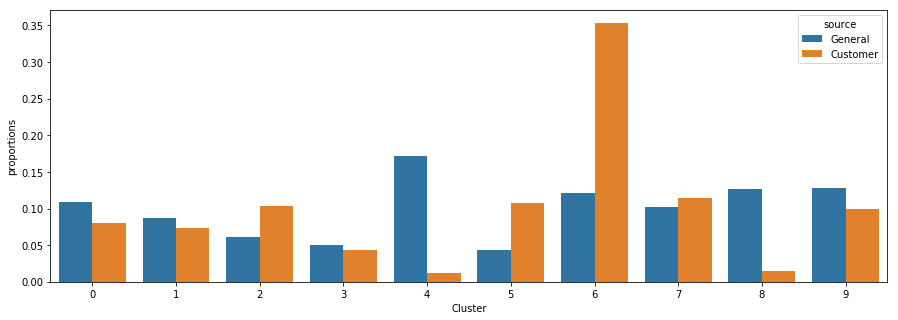

In [74]:
# Plot graph
fig, ax = plt.subplots(figsize = (15,5))

ax.set_xlabel('Cluster')
ax.set_ylabel('Proportion')

sns.barplot(ax = ax, x = full_data.index, y = full_data.proportions, hue = full_data.source)

Cluster with overrepresented in the customer data when compared to population data is 6 and 5.

Clusters with underrepresented in the customer data when compared to population are 4 and 8.

In [123]:
# Helper function to calculate inverse df
def calculate_inverse_df(cluster, kmeans, pca):
    np_cluster = np.where(kmeans == cluster)
    X = pca[np_cluster]
    inverse_data = standard_scaler.inverse_transform(pca_100.inverse_transform(X))
    inverse_data = pd.DataFrame(inverse_data, columns = azdias_low_25_nan.columns)
    
    return inverse_data

In [129]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

customer_inverse_6 = calculate_inverse_df(6, kmeans_customers_low_25_nan, pca_customers_low_25_nan)
get_pca_weight(customer_inverse_6, pca_100, 0)

LP_STATUS_GROB_1.0                0.188881
CAMEO_INTL_2015_WEALTH            0.180025
HH_EINKOMMEN_SCORE                0.179932
PLZ8_ANTG3                        0.179820
PLZ8_ANTG4                        0.174582
PLZ8_BAUMAX                       0.170426
ORTSGR_KLS9                       0.153814
EWDICHTE                          0.152200
FINANZ_HAUSBAUER                  0.146947
LP_STATUS_FEIN_1.0                0.127164
KBA05_ANTG4                       0.124502
PLZ8_ANTG2                        0.123195
ANZ_HAUSHALTE_AKTIV               0.113175
ARBEIT                            0.111915
KBA05_ANTG3                       0.111263
CAMEO_DEUG_2015_9                 0.110277
LP_STATUS_FEIN_2.0                0.106147
RELAT_AB                          0.105688
FINANZTYP_1                       0.101820
FINANZ_SPARER                     0.099598
LP_FAMILIE_FEIN_1.0               0.098755
LP_FAMILIE_GROB_1.0               0.098755
CAMEO_DEUG_2015_8                 0.090551
ZABEOTYP_5 

In [125]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

general_inverse_4 = calculate_inverse_df(4, kmeans_10_predict, pca_100_components)
get_pca_weight(general_inverse_4, pca_100, 0)

LP_STATUS_GROB_1.0                0.188881
CAMEO_INTL_2015_WEALTH            0.180025
HH_EINKOMMEN_SCORE                0.179932
PLZ8_ANTG3                        0.179820
PLZ8_ANTG4                        0.174582
PLZ8_BAUMAX                       0.170426
ORTSGR_KLS9                       0.153814
EWDICHTE                          0.152200
FINANZ_HAUSBAUER                  0.146947
LP_STATUS_FEIN_1.0                0.127164
KBA05_ANTG4                       0.124502
PLZ8_ANTG2                        0.123195
ANZ_HAUSHALTE_AKTIV               0.113175
ARBEIT                            0.111915
KBA05_ANTG3                       0.111263
CAMEO_DEUG_2015_9                 0.110277
LP_STATUS_FEIN_2.0                0.106147
RELAT_AB                          0.105688
FINANZTYP_1                       0.101820
FINANZ_SPARER                     0.099598
LP_FAMILIE_FEIN_1.0               0.098755
LP_FAMILIE_GROB_1.0               0.098755
CAMEO_DEUG_2015_8                 0.090551
ZABEOTYP_5 

### Discussion 3.3: Compare Customer Data to Demographics Data

Considering the analyzed sample, it is possible to see that no matter how much there is overrepresentation or underrepresentation, the model successfully achieves satisfactory results in most clusters.

Apparently customers are not evenly distributed in the general population, with some deviations noted in the analysis (over-representation or under-representation).

The company should consider targeting clusters 4 and 8, which have an underrepresentation of customers compared to the general sample. And you should avoid clusters 5 and 6, which already have overrepresented customers.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.